In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np

from gproc.generative import sample_at_x
from gproc.plotting import contour_2d
from gproc.kernels import *
from gproc.laplace import laplace_approximation_probit, chol_inverse, laplace_predict

In [3]:
N = 500
D = 1

x = np.random.normal(0, 1, N * D).reshape(-1, D) # Reshape to N x D matrix
true_lengthscale = 1
true_variance = 1
kernel = SquaredExponential(lengthscale = true_lengthscale, variance = true_variance)

y, prob_y, f = sample_at_x(x, kernel)

In [4]:
gram = kernel.make_gram(x, x)
inverse_gram, _ = chol_inverse(gram)

In [5]:
laplace_mean, df_ll, laplace_cov, objective_history, converged = laplace_approximation_probit(y, inverse_gram)

print(f'Converged: {converged}')

Converged: True


In [6]:
M = 100
new_x = np.linspace(-1.1, 1.1, M).reshape(-1, 1) # Reshape to N x 1 matrix

predictive_y, predictive_mean, predictive_cov = laplace_predict(new_x, x, gram, inverse_gram, laplace_mean, laplace_cov, df_ll, kernel)

/home/tt21864/Documents/Bristol/Semester 2/Group Project/gproc/src/gproc/laplace.py:123: RuntimeWarning: covariance is not positive-semidefinite.
  predictive_y = np.mean(norm.cdf(np.random.multivariate_normal(predictive_mean, predictive_cov, pred_samples)), axis=0)


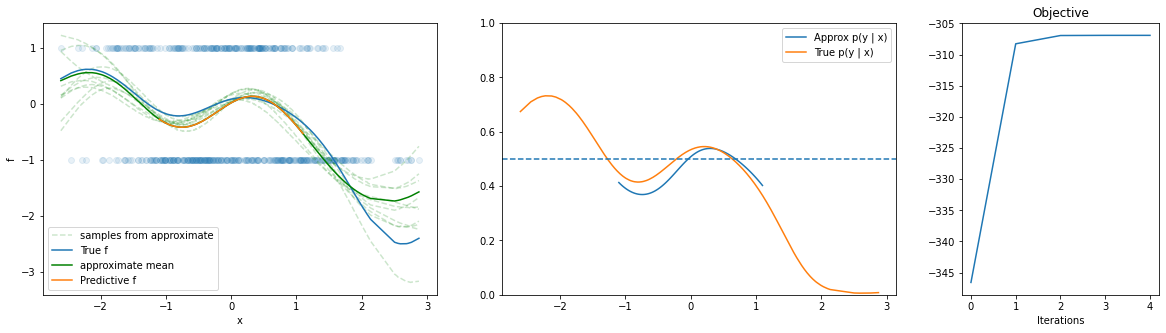

In [7]:
sort_ix = np.argsort(x.reshape(-1))

fig, axarr = plt.subplots(1, 3, figsize=(20, 5), gridspec_kw={'width_ratios': [2, 2, 1]})

axarr[2].set_title('Objective')
axarr[2].plot(objective_history)
axarr[2].set_xlabel('Iterations')

n_samples = 10
f_samp = np.random.multivariate_normal(laplace_mean, laplace_cov)
axarr[0].plot(x[sort_ix], f_samp[sort_ix], alpha=0.2, c='g', linestyle='--', label='samples from approximate')
for samp in range(n_samples - 1):
    f_samp = np.random.multivariate_normal(laplace_mean, laplace_cov)
    axarr[0].plot(x[sort_ix], f_samp[sort_ix], alpha=0.2, c='g', linestyle='--')
    
axarr[0].scatter(x, y, alpha=0.1)
axarr[0].set_xlabel('x')
axarr[0].set_ylabel('f')
axarr[0].plot(x[sort_ix], f[sort_ix], label='True f')
axarr[0].plot(x[sort_ix], laplace_mean[sort_ix], c='g', label='approximate mean') 

predictive_sort = np.argsort(new_x.reshape(-1))
axarr[0].plot(new_x[predictive_sort], predictive_mean[predictive_sort], label='Predictive f')
axarr[1].plot(new_x[predictive_sort], predictive_y[predictive_sort], label='Approx p(y | x)')
axarr[1].plot(x[sort_ix], prob_y[sort_ix], label='True p(y | x)')
axarr[0].legend()

axarr[1].set_ylim([0, 1])
axarr[1].axhline(0.5, linestyle='--')
axarr[1].legend()

plt.show()